In [1]:
import torch
from torch.utils.data import Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from data_utils import split_non_iid_dataset
from federated_learning_system import Server, n_clients, ALPHA
from model import Model

# 检查CUDA是否可用
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1736,), (0.1100,))])
train_dataset = datasets.EMNIST(root='.', split='byclass', download=True, train=True, transform=transform)

# EMNIST.class_to_idx是一个存放了映射的字典，可以帮助我们获得labels到字符的映射。
# for i, char in data.class_to_idx.items():
#     print(f"{i}: {char}")


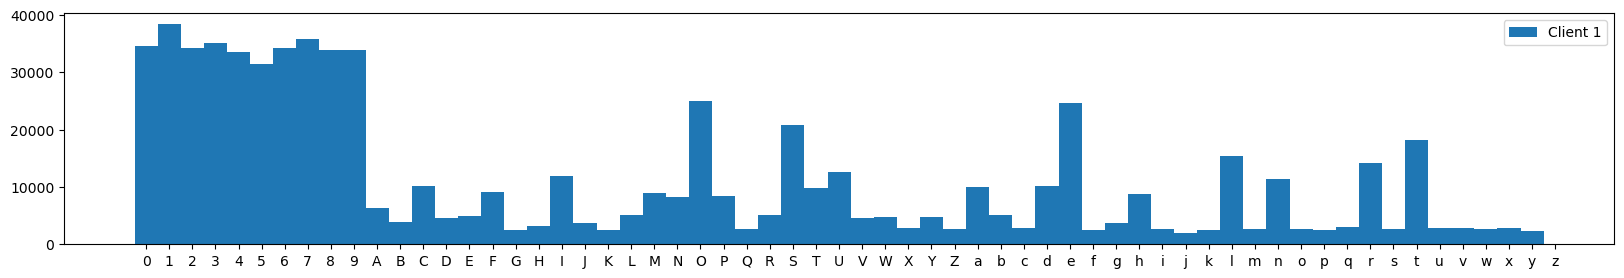

In [2]:
labels = train_dataset.targets.numpy()

# 下标数组随机排序
train_index = np.random.permutation(len(train_dataset))
train_index_by_client = split_non_iid_dataset(labels=labels, index=train_index, alpha=ALPHA, n_clients=n_clients)
train_labels = [labels[idx] for idx in train_index_by_client]
train_datasets = [Subset(train_dataset, lbl) for lbl in train_labels]

test_dataset = datasets.EMNIST(root='.', split='byclass', download=True, train=False, transform=transform)

mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
                 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
                 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
                 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1')

plt.figure(figsize=(20, 3))
# train_labels是有n_clients个list的列表
plt.hist(train_labels,
         bins=np.arange(len(mapp)) - 0.5,
         stacked=True,
         label=["Client {}".format(i + 1) for i in range(n_clients)])
plt.xticks(ticks=np.arange(62), labels=mapp)
plt.legend()
plt.show()

In [3]:
n_rounds = 2
server = Server(Model, test_dataset, n_rounds, 0.5, *train_datasets)

In [4]:
server.run()

True


KeyboardInterrupt: 